# Analysis of synthetically created SQuAD-v1.1 Training dataset

Before running, please change file paths in order to correspond to your file structure.

In [1]:
# Import modules
import os
from datasets import load_dataset
import matplotlib.pyplot as plt
import json
from transformers import AutoTokenizer

In [2]:
# Load SQuAD-sr
fname = os.path.join('../data', 'retrieve', 'squad-sr.json')
with open(fname, 'r') as f:
    squad_train = json.load(f)

## Error Analysis in Outliers
Most of analysis is performed by reviewing differences in text length for each text group.

In [3]:
# Extract lengths of context/question/answer samples
context_lens = []
question_lens = []
answer_lens = []

for d in squad_train['data']:
    for p in d['paragraphs']:
        context_lens.append(len(p['context']))
        for qa in p['qas']:
            question_lens.append(len(qa['question']))
            for a in qa['answers']:
                answer_lens.append(len(a['text']))

In [4]:
# Print average|min|max|number
print(f"CONTEXT - Average: {sum(context_lens) / len(context_lens)} | Min: {min(context_lens)} | Max: {max(context_lens)} | #: {len(context_lens)}")
print(f"QUESTION - Average: {sum(question_lens) / len(question_lens)} | Min: {min(question_lens)} | Max: {max(question_lens)} | #: {len(question_lens)}")
print(f"ANSWER - Average: {sum(answer_lens) / len(answer_lens)} | Min: {min(answer_lens)} | Max: {max(answer_lens)} | #: {len(answer_lens)}")

CONTEXT - Average: 713.8993966977138 | Min: 116 | Max: 3473 | #: 18896
QUESTION - Average: 57.444058143391395 | Min: 0 | Max: 1331 | #: 87439
ANSWER - Average: 20.19570214663937 | Min: 1 | Max: 1399 | #: 87439


Difference between average, minimum and maximum number of tokens suggest high variance in each text group. However, to make sure this is the case, histograms are computed.

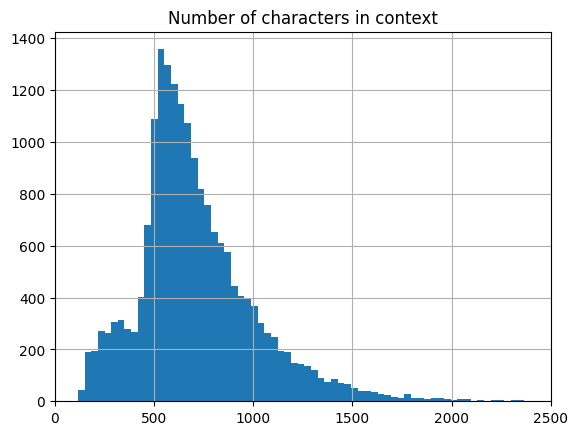

In [33]:
# Plot context lens histogram
plt.hist(context_lens, bins=100);
plt.title("Number of characters in context");
plt.xlim((0, 2500))
plt.grid();

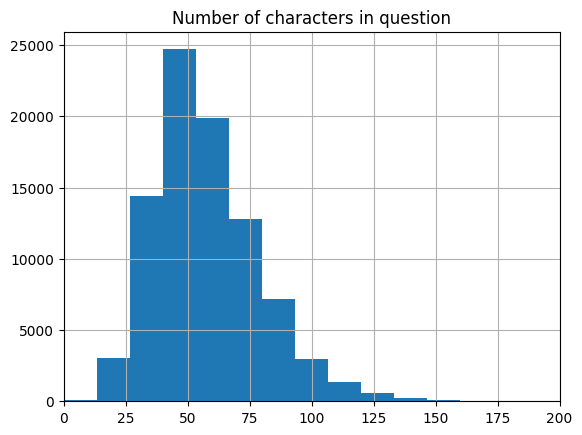

In [34]:
# Plot question lens histogram
plt.hist(question_lens, bins=100);
plt.title("Number of characters in question");
plt.xlim((0, 200))
plt.grid();

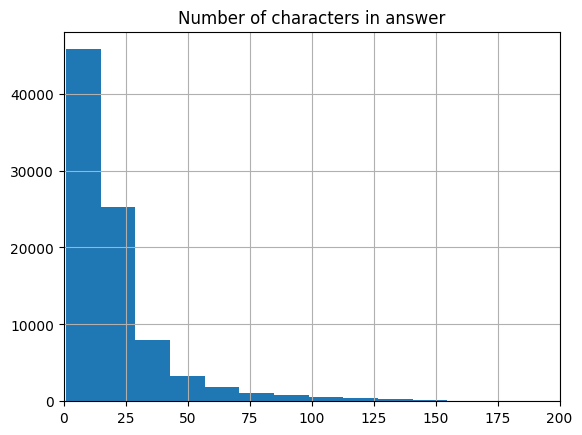

In [36]:
# Plot answer lens histogram
plt.hist(answer_lens, bins=100);
plt.title("Number of characters in answer");
plt.xlim((0, 200))
plt.grid();

Histograms above suggest that right tail of the distribution is longer for each text group. For each text group reasonable threshold is determined and about 50 outliers are manually examined.

In [8]:
# Inspect # of outliers in context lengths
print(f"Total contexts: {len(context_lens)}")
context_bar_high = 2000
context_bar_low = 150
outliers_high = sum([1 if i > context_bar_high else 0 for i in context_lens])
outliers_low = sum([1 if i < context_bar_low else 0 for i in context_lens])
print(f"There are {outliers_high} contexts with character length above {context_bar_high}")
print(f"There are {outliers_low} contexts with character length below {context_bar_low}")

Total contexts: 18896
There are 63 contexts with character length above 2000
There are 44 contexts with character length below 150


In [9]:
# Inspect # of outliers in question lengths
print(f"Total questions: {len(question_lens)}")
question_bar_high = 165
question_bar_low = 13
outliers_high = sum([1 if i > question_bar_high else 0 for i in question_lens])
outliers_low = sum([1 if i < question_bar_low else 0 for i in question_lens])
print(f"There are {outliers_high} questions with character length above {question_bar_high}")
print(f"There are {outliers_low} questions with character length below {question_bar_low}")

Total questions: 87439
There are 60 questions with character length above 165
There are 64 questions with character length below 13


In [10]:
# Inspect # of outliers in answer lengths
print(f"Total answers: {len(answer_lens)}")
answer_bar_high = 160
answer_bar_low = 2
outliers_high = sum([1 if i > answer_bar_high else 0 for i in answer_lens])
outliers_low = sum([1 if i < answer_bar_low else 0 for i in answer_lens])
outliers_zero = sum([1 if i == 0 else 0 for i in answer_lens])
print(f"There are {outliers_high} answers with character length above {answer_bar_high}")
print(f"There are {outliers_low} answers with character length below {answer_bar_low}")
print(f"There are {outliers_zero} answers with character length of exactly 0")

Total answers: 87439
There are 67 answers with character length above 160
There are 257 answers with character length below 2
There are 0 answers with character length of exactly 0


Outliers are directly compared to original texts, hoping to extract valuable information about dataset quality.

In [ ]:
# Load dataset using loading script
data_files = {
    "train": "../../data/retrieve/squad-sr.json"
}
dataset = load_dataset('../finetuning/loading_script.py', data_files=data_files)

In [3]:
dataset = dataset['train']

In [20]:
# Save long contexts
long_contexts = set()
for d in dataset:
    if len(d['context']) > context_bar_high:
        long_contexts.add(d['context'])

text = ''
for c in long_contexts:
    text += c + '\n---\n'

with open('../data/dataset_analysis/extraction/long_contexts.txt', 'w') as f:
    f.write(text)

Examination of long contexts has shown that there are multiple occurencies of repeating same words. This error is propagated from translation model, which sometimes enters some kind of infinity loop.

In [21]:
# Save long questions
long_questions = set()
for d in dataset:
    if len(d['question']) > question_bar_high:
        long_questions.add(d['question'])

text = ''
for c in long_questions:
    text += c + '\n---\n'

with open('../data/dataset_analysis/extraction/long_questions.txt', 'w') as f:
    f.write(text)

Same conclusion is drawn for long questions.

In [23]:
# Save long answers
long_answers = set()
long_answers_dict = {}
for d in dataset:
    if len(d['answers']['text'][0]) > answer_bar_high:
        long_answers.add(d['answers']['text'][0])
        long_answers_dict[d['id']] = d['answers']['text'][0]

text = ''
for c in long_answers:
    text += c + '\n---\n'

with open('../data/dataset_analysis/extraction/long_answers.txt', 'w') as f:
    f.write(text)

In [24]:
# Compare translated answers to original answers
with open('../data/squad-original/train-v1.1.json', 'r') as f:
    squad_original = json.load(f)

text = ''
for d in squad_original['data']:
    for p in d['paragraphs']:
        for qa in p['qas']:
            if qa['id'] in long_answers_dict.keys():
                text += qa['answers'][0]['text']
                text += '\n--\n'
                text += long_answers_dict[qa['id']]
                text += '\n------------\n'

with open('../data/dataset_analysis/extraction/long_answers_comparison.txt', 'w') as f:
    f.write(text)

Since answers are extracted directly from contexts, existence of repeating words in long contexts produces errors in corresponding answers. Because of incorrect translation, Word Aligner is unable to correctly map source to target words in answers, which ultimately produces answer much longer than required.

In [25]:
# Save short contexts
short_contexts = set()
short_contexts_dict = {}
for d in dataset:
    if len(d['context']) < context_bar_low:
        short_contexts.add(d['context'])
        short_contexts_dict[d['id']] = d['context']

text = ''
for c in short_contexts:
    text += c + '\n---\n'

with open('../data/dataset_analysis/extraction/short_contexts.txt', 'w') as f:
    f.write(text)

In [26]:
# Compare short contexts to original
text = ''
for d in squad_original['data']:
    for p in d['paragraphs']:
        for qa in p['qas']:
            if qa['id'] in short_contexts_dict.keys():
                text += p['context']
                text += '\n--\n'
                text += short_contexts_dict[qa['id']]
                text += '\n------------\n'

with open('../data/dataset_analysis/extraction/short_contexts_comparison.txt', 'w') as f:
    f.write(text)

By comparing short target contexts with corresponding source contexts, no particular conclusion is drawn. Zero errors are noticed.

In [27]:
# Save short questions
short_questions = set()
short_questions_dict = {}
for d in dataset:
    if len(d['question']) < question_bar_low:
        short_questions.add(d['question'])
        short_questions_dict[d['id']] = d['question']

text = ''
for c in short_questions:
    text += c + '\n---\n'

with open('../data/dataset_analysis/extraction/short_questions.txt', 'w') as f:
    f.write(text)

In [28]:
# Compare short questions to original
text = ''
for d in squad_original['data']:
    for p in d['paragraphs']:
        for qa in p['qas']:
            if qa['id'] in short_questions_dict.keys():
                text += qa['id']
                text += '\n-\n'
                text += qa['question']
                text += '\n--\n'
                text += short_questions_dict[qa['id']]
                text += '\n------------\n'

with open('../data/dataset_analysis/extraction/short_questions_comparison.txt', 'w') as f:
    f.write(text)

Most of errors in short questions come from the original dataset. All of them come from the same context, which means they come from the same labeler.

In [29]:
# Save short answers
short_answers = set()
short_answers_dict = {}
for d in dataset:
    if len(d['answers']['text'][0]) < answer_bar_low:
        short_answers.add(d['answers']['text'][0])
        short_answers_dict[d['id']] = d['answers']['text'][0]

text = ''
for c in short_answers:
    text += c + '\n---\n'

with open('../data/dataset_analysis/extraction/short_answers.txt', 'w') as f:
    f.write(text)

In [30]:
# Compare short answers to original
text = ''
for d in squad_original['data']:
    for p in d['paragraphs']:
        for qa in p['qas']:
            if qa['id'] in short_answers_dict.keys():
                text += qa['id']
                text += '\n-\n'
                text += qa['answers'][0]['text']
                text += '\n--\n'
                text += short_answers_dict[qa['id']]
                text += '\n------------\n'

with open('../data/dataset_analysis/extraction/short_answers_comparison.txt', 'w') as f:
    f.write(text)

Errors in short answers come from incorrect word alignments.

## Question Type Analysis

Different types of questions require the model to extract different type of information from context. In order to check if the dataset is diverse enough, as well as compare it to original SQuAD values, all questions are labeled based on question word they contain.

In [9]:
# Question types
counts = {}
question_types = ["Ko ", "Šta ", "Gde ", "Kad ", "Kada ", "Kako ", "Koliko ", "Da li ", "Kim ", "Koga ", "Kome ", "Koji "]

for qt in question_types:
    counts[qt] = sum([1 for q in dataset['question'] if (qt.lower() in q.lower())])


In [11]:
total = sum(counts.values())
for k, v in counts.items():
    print(f"{k} - {v} - {v/total*100:.2f}%")

print(sum(counts.values()))

Ko  - 24898 - 30.75%
Šta  - 11645 - 14.38%
Gde  - 3286 - 4.06%
Kad  - 197 - 0.24%
Kada  - 6996 - 8.64%
Kako  - 6523 - 8.06%
Koliko  - 8449 - 10.44%
Da li  - 1204 - 1.49%
Kim  - 1751 - 2.16%
Koga  - 393 - 0.49%
Kome  - 584 - 0.72%
Koji  - 15037 - 18.57%
80963


Text(0.5, 1.0, 'Učestanost upitnih reči')

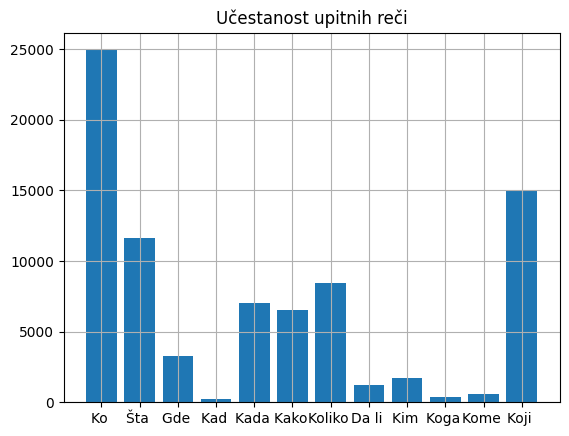

In [ ]:
plt.bar(counts.keys(), counts.values())
plt.grid()
plt.title('Učestanost upitnih reči')